In [4]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt
import os, copy
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import rexnetv1

In [5]:
''' 2. 딥러닝 모델을 설계할 때 활요하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


In [82]:
BATCH_SIZE = 2
EPOCHS = 10
LEARNING_RATE = 0.0005
OPTIM = 'SGD' # Adam
MODEL = 'RexNet' # ResNet34 ResNet18 RexNet

In [83]:
''' 3. 이미지 데이터 불러오기(Train set, Test set 분리하기)'''
# preprocessing 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])
}

class Data:
    def __init__(self, img_path, txt_path, transforms = None):
        with open(txt_path, 'r') as f:
            lines = f.readlines()
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.label_list = [i.split()[1] for i in lines]
            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)

img_path = '/root/share/datasets/ICNGC_data'
trainset_txt = {'fold1': './splits/Custom_Paper/fold2345_all.txt',
                'fold2': './splits/Custom_Paper/fold1345_all.txt',
                'fold3': './splits/Custom_Paper/fold1245_all.txt',
                'fold4': './splits/Custom_Paper/fold1235_all.txt',
                'fold5': './splits/Custom_Paper/fold1234_all.txt'
               }
testset_txt = {'fold1': './splits/Custom_Paper/fold1_all.txt',
               'fold2': './splits/Custom_Paper/fold2_all.txt',
               'fold3': './splits/Custom_Paper/fold3_all.txt',
               'fold4': './splits/Custom_Paper/fold4_all.txt',
               'fold5': './splits/Custom_Paper/fold5_all.txt',
              }

train_loader = {}
test_loader = {}

for i in range(len(trainset_txt)):
    train_dataset = Data(img_path, trainset_txt['fold'+str(i+1)], data_transforms['train'])
    test_dataset = Data(img_path, testset_txt['fold'+str(i+1)], data_transforms['val'])
    train_loader['fold'+str(i+1)] = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_loader['fold'+str(i+1)] = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [84]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader['fold1']:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', len(y_train), 'type:', type(y_train))
    break

X_train: torch.Size([2, 3, 224, 224]) type: torch.FloatTensor
y_train: 2 type: <class 'tuple'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


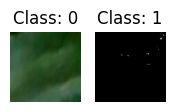

In [85]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(BATCH_SIZE * pltsize, pltsize))

for i in range(BATCH_SIZE):
    plt.subplot(1, BATCH_SIZE, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i]))

In [86]:
''' 6. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        label = list(map(int, label))
        label = torch.Tensor(label)
        image = image.to(DEVICE) # 기존 정의한 장비에 할당
        label = label.to(DEVICE) # 기존 정의한 장비에 할당
        optimizer.zero_grad() # 기존 할당되어 있던 gradient 값 초기화
        output = model(image) # Forward propagation
        loss = criterion(output, label.long()) # loss 계산
        loss.backward() # Backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                  Epoch, batch_idx * len(image),
                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                  loss.item()))

In [87]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가하는 단계에서 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:
            label = list(map(int, label))
            label = torch.Tensor(label)
            image = image.to(DEVICE) # 기존 정의한 장비에 할당
            label = label.to(DEVICE) # 기존 정의한 장비에 할당
            output = model(image) # Forward propagation
            test_loss += criterion(output, label.long()).item() # loss 누적
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
            
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

In [88]:
import torchvision.models as models

if MODEL == 'AlexNet':
    model = models.alexnet(pretrained=False)
    model._modules['classifier']._modules['6'] = nn.Linear(4096, 2, bias=True)
elif MODEL == 'ResNet18':
    model = models.resnet18(num_classes=2, pretrained=False)
elif MODEL == 'ResNet34':
    model = models.resnet34(num_classes=2, pretrained=False)
elif MODEL == 'ResNet50':
    model = models.resnet50(num_classes=2, pretrained=False)
elif MODEL == 'ResNet101':
    model = models.resnet101(num_classes=2, pretrained=False)
elif MODEL == 'RexNet': # BATCH_SIZE 1은 에러남
    model = rexnetv1.ReXNetV1(width_mult=1.0).cuda()
    print(model(torch.randn(BATCH_SIZE, 3, 224, 224).cuda())) 
    
init_model = copy.deepcopy(model)
print(init_model)

#for children in model.classifier.children():
#    if isinstance(children, nn.Linear):
#        if children.out_features == 1000:
#            print(children)

tensor([[-0.1231,  0.0724,  0.0723,  ...,  0.2914,  0.1601,  0.1923],
        [ 0.1293,  0.0940,  0.0830,  ...,  0.0718,  0.2748,  0.0245]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
ReXNetV1(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): LinearBottleneck(
      (out): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6()
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): LinearBottleneck(
      (out): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False

In [89]:
SAVE_PATH = './saved_model'
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    
for dataset in trainset_txt.keys():
    print("------------------    For ", dataset, " dataset    ------------------")
    
    model = copy.deepcopy(init_model)
    model = model.cuda()
    
    if OPTIM == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
    elif OPTIM == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()
    
    best_acc = 0
    best_ep = 0
    
    for Epoch in range(1, EPOCHS + 1):
        train(model, train_loader[dataset], optimizer, log_interval = 200)
        test_loss, test_accuracy = evaluate(model, test_loader[dataset])
        if test_accuracy > best_acc:
            best_acc = test_accuracy
            best_model = copy.deepcopy(model)
            best_ep = Epoch
            print("Best Model!")
        print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy), '\r')

    torch.save(best_model.state_dict(), SAVE_PATH+"/{}_BS{}_{}_LR{}_EP{}_DS-{}.pt".format(MODEL, BATCH_SIZE, OPTIM, str(LEARNING_RATE).split('.')[1], EPOCHS, dataset))
    print("------------------    Best Model at Epoch {} Saved    ------------------".format(best_ep))

------------------    For  fold1  dataset    ------------------
Train Epoch: 1 [0/1877(0%)]	Train Loss: 6.801125
Train Epoch: 1 [400/1877(21%)]	Train Loss: 0.534126
Train Epoch: 1 [800/1877(43%)]	Train Loss: 0.737911
Train Epoch: 1 [1200/1877(64%)]	Train Loss: 0.738293
Train Epoch: 1 [1600/1877(85%)]	Train Loss: 0.472382
Best Model!

EPOCH: 1], 	Test Loss: 1.0246, 	Test Accuracy: 55.79 %
 
Train Epoch: 2 [0/1877(0%)]	Train Loss: 1.058674
Train Epoch: 2 [400/1877(21%)]	Train Loss: 0.668402
Train Epoch: 2 [800/1877(43%)]	Train Loss: 0.613803
Train Epoch: 2 [1200/1877(64%)]	Train Loss: 0.952016
Train Epoch: 2 [1600/1877(85%)]	Train Loss: 0.752922
Best Model!

EPOCH: 2], 	Test Loss: 0.6194, 	Test Accuracy: 57.51 %
 
Train Epoch: 3 [0/1877(0%)]	Train Loss: 0.141874
Train Epoch: 3 [400/1877(21%)]	Train Loss: 0.685110
Train Epoch: 3 [800/1877(43%)]	Train Loss: 0.091813
Train Epoch: 3 [1200/1877(64%)]	Train Loss: 0.930350
Train Epoch: 3 [1600/1877(85%)]	Train Loss: 0.512550
Best Model!

EPOCH:

Train Epoch: 5 [800/1878(43%)]	Train Loss: 0.596341
Train Epoch: 5 [1200/1878(64%)]	Train Loss: 0.258023
Train Epoch: 5 [1600/1878(85%)]	Train Loss: 0.609317
Best Model!

EPOCH: 5], 	Test Loss: 0.2632, 	Test Accuracy: 88.60 %
 
Train Epoch: 6 [0/1878(0%)]	Train Loss: 0.040664
Train Epoch: 6 [400/1878(21%)]	Train Loss: 0.737749
Train Epoch: 6 [800/1878(43%)]	Train Loss: 0.266073
Train Epoch: 6 [1200/1878(64%)]	Train Loss: 0.242428
Train Epoch: 6 [1600/1878(85%)]	Train Loss: 0.504457
Best Model!

EPOCH: 6], 	Test Loss: 0.2312, 	Test Accuracy: 90.75 %
 
Train Epoch: 7 [0/1878(0%)]	Train Loss: 0.734522
Train Epoch: 7 [400/1878(21%)]	Train Loss: 0.390748
Train Epoch: 7 [800/1878(43%)]	Train Loss: 0.050801
Train Epoch: 7 [1200/1878(64%)]	Train Loss: 0.729975
Train Epoch: 7 [1600/1878(85%)]	Train Loss: 1.227333
Best Model!

EPOCH: 7], 	Test Loss: 0.1562, 	Test Accuracy: 94.19 %
 
Train Epoch: 8 [0/1878(0%)]	Train Loss: 0.608582
Train Epoch: 8 [400/1878(21%)]	Train Loss: 0.788761
Train Epoch: 


EPOCH: 9], 	Test Loss: 0.0623, 	Test Accuracy: 95.59 %
 
Train Epoch: 10 [0/1867(0%)]	Train Loss: 0.921399
Train Epoch: 10 [400/1867(21%)]	Train Loss: 0.833272
Train Epoch: 10 [800/1867(43%)]	Train Loss: 1.021673
Train Epoch: 10 [1200/1867(64%)]	Train Loss: 0.047411
Train Epoch: 10 [1600/1867(86%)]	Train Loss: 1.256786

EPOCH: 10], 	Test Loss: 0.0679, 	Test Accuracy: 96.01 %
 
------------------    Best Model at Epoch 8 Saved    ------------------


# 훈련된 모델 확인

In [97]:
total_loss = 0

for dataset in trainset_txt.keys():
    model_path = SAVE_PATH+"/{}_BS{}_{}_LR{}_EP{}_DS-{}.pt".format(MODEL, BATCH_SIZE, OPTIM, str(LEARNING_RATE).split('.')[1], EPOCHS, dataset)
    
    if MODEL == 'AlexNet':
        trained_model = models.alexnet(pretrained=False)
        trained_model._modules['classifier']._modules['6'] = nn.Linear(4096, 2, bias=True)
    elif MODEL == 'ResNet18':
        trained_model = models.resnet18(num_classes=2, pretrained=False)
    elif MODEL == 'ResNet34':
        trained_model = models.resnet34(num_classes=2, pretrained=False)
    elif MODEL == 'ResNet50':
        trained_model = models.resnet50(num_classes=2, pretrained=False)
    elif MODEL == 'ResNet101':
        trained_model = models.resnet101(num_classes=2, pretrained=False)
    elif MODEL == 'RexNet': # BATCH_SIZE 1은 에러남
        trained_model = rexnetv1.ReXNetV1(width_mult=1.0).cuda()
        
    trained_model = trained_model.cuda()
    trained_model.load_state_dict(torch.load(model_path))
    
    test_loss, test_accuracy = evaluate(trained_model, test_loader[dataset])
    total_loss += test_accuracy
    print('{} - loss: {}, acc: {}'.format(dataset, test_loss, test_accuracy))
    
total_loss /= len(trainset_txt)
print("average accuracy: ", total_loss)

fold1 - loss: 0.11164460807654991, acc: 94.84978540772532
fold2 - loss: 0.09926515798558146, acc: 93.73650107991361
fold3 - loss: 0.08881148990202678, acc: 94.83870967741936
fold4 - loss: 0.0991357247684243, acc: 93.446088794926
fold5 - loss: 0.08323272871166887, acc: 96.00840336134453
average accuracy:  94.57589766426577
